In [1]:
import torch
import torch.nn as nn
import numpy as np
import math
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from numpy.random import *


seed =2
#np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

/Users/ikaridaka/Documents/research_B3/test/.venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#@title create sample_data
def create_8_data(points_per_1circle, num_of_round)-> 'numpy':
    
    data_sample = np.zeros([num_of_round, points_per_1circle, 2])

    for i in range(num_of_round):
        data_sample[i] = mk_oneCircle(points_per_1circle)

    print("data_sample.shape : {}".format(data_sample.shape))
    return data_sample

def mk_oneCircle(points_per_1circle):
    T = points_per_1circle
    t = np.linspace(0, T, T)
    x = np.cos(2*np.pi*t/T) + np.random.normal(0, 0.05, T)
    y = np.sin(2*2*np.pi*t/T + np.pi) + np.random.normal(0, 0.05, T)
    one_circle_data = np.stack([x, y], axis = 1)

    #原点を通るように調整
    one_circle_data[int(T/4), :] = np.zeros([1, 2])
    one_circle_data[int(T/4+T/2), :] = np.zeros([1, 2])

    return one_circle_data

 


In [3]:
class DotDataset(torch.utils.data.Dataset):
    def __init__(self, input_data, target_data):
        self.input_data = input_data
        self.target_data = target_data

    def __len__(self):
        return self.input_data.shape[0]

    def __getitem__(self, idx):
        input_datum = torch.from_numpy(self.input_data[idx]).float()
        target_datum = torch.from_numpy(self.target_data[idx]).float()
        return input_datum, target_datum 

def create_dataloader(batchsize, data_sample):

    indeces = [int(data_sample.shape[0] * 0.7)]
    train_data, val_data = np.split(data_sample, indeces, axis=0)
    train_data, val_data = np.split(data_sample, indeces, axis=0)

    train_input_data = train_data[:,0:-2, :]
    train_target_data = train_data[:, 1 :-1 , :]
    val_input_data = val_data[: , 0 : -2, :]
    val_target_data = val_data[: , 1 : -1, :]

    train_dataset = DotDataset(train_input_data, train_target_data)
    val_dataset = DotDataset(val_input_data, val_target_data)
    
    train_dataloader = DataLoader(train_dataset, batch_size = batchsize)
    val_dataloader = DataLoader(val_dataset, batch_size = batchsize)

    return train_dataloader, val_dataloader, train_input_data, val_input_data


In [4]:
#input(np.narray, string{title})
def visualize_data(data, data_name):
    print("data.shape = {}".format(data.shape))
    data = np.reshape(data, (-1, 2))
    x,y = np.split(data, 2, axis = 1)
    plt.plot(x, y, label = data_name) 
    plt.savefig("sample8data")

def visualize_loss(loss_dict, epochs, fig_name):
    
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.plot(loss_dict['train'], linestyle="solid")
    ax.plot(loss_dict['val'], linestyle="dashed")
    ax.set_yscale('log')
    ax.legend(['train_loss', 'val_loss'])
    ax.set_xlim(0, epochs)
    ax.set_title('loss')
    fig.savefig(fig_name + '.png')


def visualize_test(prediction, targets, fig_name):
    
    x_pred,y_pred = np.split(prediction, 2, axis = 1)
    x_target,y_target = np.split(targets, 2, axis = 1)
    print("{} : 表示開始".format(fig_name))

    # for i in range(x_target.shape[0]):
    #     print("x_pred={}, y_pred={}".format(x_pred[i], y_pred[i]))
    #     print("x_target={}, y_target={}".format(x_target[i], y_target[i]))
    
    fig = plt.figure()
    ax = fig.add_subplot()
    
    ax.scatter(x_target,y_target, c = "coral")
    predictions = ax.scatter(x_pred, y_pred, c=range(50),s=30, cmap='GnBu')
    fig.colorbar(predictions, ax=ax)
    
    ax.legend(['target', 'pred'])
    
    ax.set_title('compare_pred-target')
    plt.savefig(fig_name + '_test.png')

  

In [5]:
def RNNtrain(model, criterion, optimizer, epochs, batch_size,data_sample, lr):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    torch.manual_seed(seed)    
    train_dataloader, val_dataloader, \
    train_input_data, val_input_data = create_dataloader(batch_size, data_sample)
    optimizer = optimizer(model.parameters(), lr=lr)

    # 各epochでのloss, accを保存する配列
    loss_dict = {'train': [], 'val': []}

    for epoch in range(epochs):
        #学習
        train_loss = 0
        val_loss = 0
        
        model.train()
        h = torch.zeros(batch_size, model.hidden_size)
        for inputs, targets in train_dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            predictions = model(inputs)
            loss = criterion(predictions, targets)
                  
            model.zero_grad()
            loss.backward()
            optimizer.step()
        
        #性能評価(汎化ではない)
        model.eval()
        with torch.no_grad():
            for inputs, targets in train_dataloader:
                inputs, targets = inputs.to(device), targets.to(device)
                predictions= model(inputs)
                loss = criterion(predictions, targets)
                train_loss += loss

            for inputs, targets in val_dataloader:
                inputs, targets = inputs.to(device), targets.to(device)  
                predictions = model(inputs)
                loss = criterion(predictions, targets)  
                val_loss += loss

            loss_dict["train"].append(train_loss/train_input_data.shape[0])
            loss_dict["val"].append(val_loss/ val_input_data.shape[0])

        print("Epoch: {}/{} ".format(epoch + 1, epochs),
            "Traning Loss: {} ".format(train_loss/train_input_data.shape[0]),
            "Validation Loss: {}".format(val_loss/ val_input_data.shape[0]))    

    visualize_loss(loss_dict, epochs, "RNN_loss")
    return model

In [6]:
#@title test_func
def mk_target_data(points_per_1circle):
    T = points_per_1circle
    t = np.linspace(0, T, T)
    x = np.cos(2*np.pi*t/T)
    y = np.sin(2*2*np.pi*t/T + np.pi)
    one_circle_data = np.stack([x, y], axis = 1)

    return one_circle_data


def RNNtest(model, criterion, points_1circle):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")   
    test_loss = 0
    input = torch.zeros(1,2)
    input[0, 0] = 1
    input = input.to(device)
    predictions = torch.zeros(points_1circle, 2, dtype=float)
    targets = torch.from_numpy(mk_target_data(points_1circle))
    predictions[0, :] = input
    h = None
    
    model.eval()
    with torch.no_grad():
        for i in range(points_1circle-1):
            prediction, h = model.autoregress(input, h)
            #print(h.shape)
            predictions[i+1, :] = prediction.unsqueeze(0)
            input = prediction
            input = input.to(device)

    test_loss = criterion(predictions, targets)
    
    print("FNNtest_loss = {}".format(test_loss / points_1circle))
    visualize_test(predictions, targets, "RNN")



In [7]:
#@title model_definition
class RNN(nn.Module):
    def __init__(self, input_size , hidden_size, num_layer):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layer = num_layer
        self.rnn = nn.RNN(input_size=self.input_size, hidden_size=self.hidden_size,\
                          num_layers= num_layer, batch_first=True)
        self.fc = nn.Linear(hidden_size, 2)
       

    def forward(self, x):
        x, h = self.rnn(x, None)
        x = self.fc(x)
        return x

    def autoregress(self, x, h):
        x, h = self.rnn(x, h)
        x = self.fc(x)
        return x, h

        

data_sample.shape : (100, 50, 2)
data.shape = (100, 50, 2)


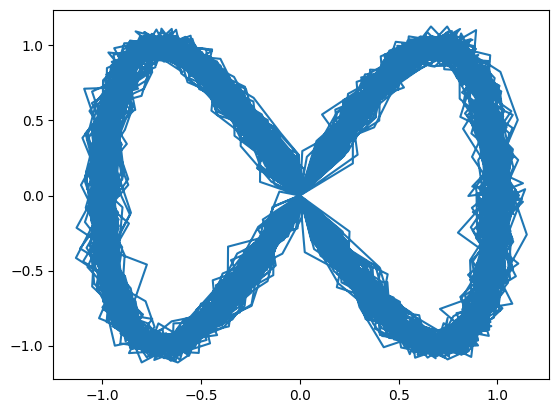

In [8]:
data_sample = create_8_data(points_per_1circle=50, num_of_round=100)
visualize_data(data_sample, "data_sample")



Epoch: 1/1000  Traning Loss: 0.04287010803818703  Validation Loss: 0.043002963066101074
Epoch: 2/1000  Traning Loss: 0.03845536708831787  Validation Loss: 0.03857618570327759
Epoch: 3/1000  Traning Loss: 0.03420913591980934  Validation Loss: 0.03431737422943115
Epoch: 4/1000  Traning Loss: 0.030029157176613808  Validation Loss: 0.030124159529805183
Epoch: 5/1000  Traning Loss: 0.025848617777228355  Validation Loss: 0.025929976254701614
Epoch: 6/1000  Traning Loss: 0.02174190618097782  Validation Loss: 0.021809985861182213
Epoch: 7/1000  Traning Loss: 0.01808781363070011  Validation Loss: 0.018144695088267326
Epoch: 8/1000  Traning Loss: 0.015267297625541687  Validation Loss: 0.015316784381866455
Epoch: 9/1000  Traning Loss: 0.01296906266361475  Validation Loss: 0.013014237396419048
Epoch: 10/1000  Traning Loss: 0.011014629155397415  Validation Loss: 0.011056655086576939
Epoch: 11/1000  Traning Loss: 0.009480304084718227  Validation Loss: 0.009518844075500965
Epoch: 12/1000  Traning Los

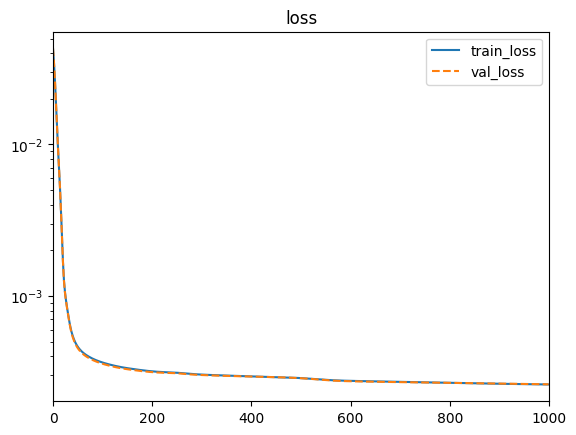

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.MSELoss()  # Loss定義
optimizer = torch.optim.Adam
batch_size = 10

model = RNN(input_size=2, hidden_size=20, num_layer=1).to(device)

model = RNNtrain(
    model=model, criterion=criterion, optimizer=optimizer, epochs=1000, batch_size=batch_size,data_sample=data_sample, lr=0.00078
)


FNNtest_loss = 4.000573059150737e-06
RNN : 表示開始


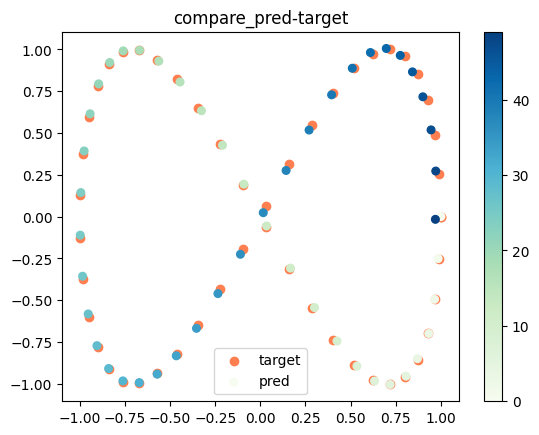

In [10]:

RNNtest(model = model, criterion=criterion, points_1circle=50)